<b>Variational Autoencoder</b>

In [1]:
import numpy as np
import torch

seed = 100
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [2]:
# Dataset

from torchvision import datasets, transforms
import torch.utils as utils

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1))])

dataset_train = datasets.MNIST(
    '~/mnist', 
    train=True, 
    download=True, 
    transform=transform)
dataset_test  = datasets.MNIST(
    '~/mnist', 
    train=False, 
    download=True, 
    transform=transform)

batch_size = 1000

dataloader_train = utils.data.DataLoader(dataset_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)
dataloader_test  = utils.data.DataLoader(dataset_test,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=4)

In [3]:
# Network

import torch.nn as nn

class VAE(nn.Module):
  def __init__(self, z_dim):
    super(VAE, self).__init__()
    self.encoder = nn.Sequential(
        nn.Linear(28*28, 300),
        nn.ReLU(),
        nn.Linear(300, 200),
        nn.ReLU(),
    )
    self.encmean = nn.Sequential(
        nn.Linear(200, z_dim),
    )
    self.encvar = nn.Sequential(
        nn.Linear(200, z_dim),
        nn.Softplus()
    )
    self.decoder = nn.Sequential(
        nn.Linear(z_dim, 200),
        nn.ReLU(),
        nn.Linear(200, 300),
        nn.ReLU(),
        nn.Linear(300, 28*28),
        nn.Sigmoid(),
    )

  def sample_z(self, mean, var):
    epsilon = torch.randn(mean.shape).to(device)
    return mean + torch.sqrt(var) * epsilon

  def forward(self, x1):
    x2 = self.encoder(x1)
    mean = self.encmean(x2)
    var = self.encvar(x2)
    z = self.sample_z(mean, var)
    y = self.decoder(z)
    return y, z

  def loss(self, x1):
    x2 = self.encoder(x1)
    mean = self.encmean(x2)
    var = self.encvar(x2)
    KL = -0.5 * torch.mean(torch.sum(1 + torch.log(var) - mean**2 - var))
    z = self.sample_z(mean, var)
    y = self.decoder(z)
    reconstruction = torch.mean(torch.sum(x1 * torch.log(y) + (1 - x1) * torch.log(1 - y)))
    lower_bound = [-KL, reconstruction]                                      
    return -sum(lower_bound)

In [4]:
# Training

from torch import optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(10).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for i in range(20):
  print(f"EPOCH: {i+1}")

  ### Train ###
  model.train()
  for x, _ in dataloader_train:
    x = x.to(device)
    model.zero_grad()
    y, _ = model(x)
    loss = model.loss(x)/batch_size
    loss.backward()
    optimizer.step()

  model.eval()
  sum_loss = 0.0
  sum_iter = 0
  for x, _ in dataloader_train:
    x = x.to(device)
    y, _ = model(x)
    loss = model.loss(x)/batch_size
    sum_loss += loss.cpu().detach().numpy()
    sum_iter += 1
  print(f"  train loss: {sum_loss/sum_iter}")

  ### Test ###
  model.eval()
  sum_loss = 0.0
  sum_iter = 0
  for x, _ in dataloader_test:
    x = x.to(device)
    y, _ = model(x)
    loss = model.loss(x)/batch_size
    sum_loss += loss.cpu().detach().numpy()
    sum_iter += 1
  print(f"  test  loss: {sum_loss/sum_iter}")


EPOCH: 1
  train loss: 202.90272216796876
  test  loss: 202.62072296142577
EPOCH: 2
  train loss: 188.52162373860676
  test  loss: 187.77696838378907
EPOCH: 3
  train loss: 168.82948379516603
  test  loss: 168.0345886230469
EPOCH: 4
  train loss: 157.00825932820638
  test  loss: 156.22129821777344
EPOCH: 5
  train loss: 143.6308344523112
  test  loss: 142.63793029785157
EPOCH: 6
  train loss: 136.1634506225586
  test  loss: 135.2000701904297
EPOCH: 7
  train loss: 132.5168561299642
  test  loss: 131.6765380859375
EPOCH: 8
  train loss: 130.14852294921874
  test  loss: 129.25236129760742
EPOCH: 9
  train loss: 127.6758804321289
  test  loss: 126.83805465698242
EPOCH: 10
  train loss: 125.68174870808919
  test  loss: 124.82825622558593
EPOCH: 11
  train loss: 124.41227862040202
  test  loss: 123.50380096435546
EPOCH: 12
  train loss: 122.86649475097656
  test  loss: 122.06987152099609
EPOCH: 13
  train loss: 121.14992866516113
  test  loss: 120.36933059692383
EPOCH: 14
  train loss: 119.

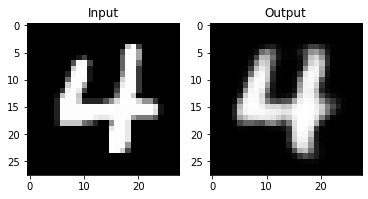

In [ ]:
# Visualization

import matplotlib.pyplot as plt
%matplotlib inline

x, t = iter(dataloader_test).next()
x = x.to(device)
y, _ = model(x)
x = np.reshape(x[0].cpu().detach().numpy(), [28, 28])
y = np.reshape(y[0].cpu().detach().numpy(), [28, 28])

plt.gray()
plt.subplot(121)
plt.imshow(x)
plt.title("Input")
plt.subplot(122)
plt.imshow(y)
plt.title("Output")
plt.show()

参考<br>
https://www.sambaiz.net/article/212/<br>
https://qiita.com/kenmatsu4/items/b029d697e9995d93aa24<br>